# NCoR RNA-seq Analysis

In [2]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/home/jenhan/analysis/ncor_analysis/')
import pickle
sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocessing

In [13]:
# file directories
workingDirectory = '/home/jenhan/analysis/ncor_analysis/'
binDirectory = '/home/jenhan/bin/'
dgenomes = ['hg19','mm10']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files_thiomacRNA/'
tagDirectory = workingDirectory + '/tag_directories_thiomacRNA/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)

# map ugly file names to prettier looking file names
if not os.path.isfile("nameMapping.tsv"):
    nameMappingFile = open("nameMapping.tsv", "w")
    for f in os.listdir(tagDirectory):
        for gen in genomes:
            rootName = f.replace('.' + gen + '.star.log','').replace('.' +gen + '.bowtie2.log','')
        nameMappingFile.write(rootName + '\t' + rootName + '\n')
    nameMappingFile.close()

# read in and parse name mapping file and create a DataFrame representation
with open("nameMapping.tsv") as f:
    data = f.readlines()
strains = []
treatments = []
owners = []
dates = []
originalNames = []
cleanedNames = []
for line in data:
    tokens = line.strip().split("\t")
    originalName = tokens[0]
    metaDataTokens = tokens[1].split('_')
    
    originalNames.append(originalName)
    cleanedNames.append(tokens[1])
    # grab metadata from string tokens
    strain = metaDataTokens[1].strip()
    treatment = metaDataTokens[4].strip()
    owner = metaDataTokens[5].strip()
#     date = metaDataTokens[4].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
#     dates.append(date)
    
metadata_frame = pd.DataFrame([strains, 
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  cleanedNames]).transpose()
metadata_frame.columns = ['strain', 
                         'treatment', 
                         'owner', 
                         'originalName', 
                         'sampleName']

simpleTreatments = []
for t in list(metadata_frame['treatment'].values):
    st = t.split('-')[0]
    simpleTreatments.append(st)
metadata_frame['simpleTreatment'] = simpleTreatments

# create dictionary for convenience
originalName_cleanedName_dict = dict(zip(metadata_frame["originalName"], metadata_frame["sampleName"])) # {originalName:newName}
cleanedName_originalName_dict = dict(zip(metadata_frame["sampleName"], metadata_frame["originalName"])) # {newName:originalName}

### read in log files ###

# # create data frame summarizing mapping quality logs
# # _sampleNames = []
# _totalReads = []
# _unpairedReads = []
# _unmappedReads = []
# _uniquelyMappedReads = []
# _multiMappedReads = []
# _originalNames =[]
# _pbc = []
# for logFile in os.listdir(logFilePath):
#     with open(logFilePath + '/' + logFile) as f:
#         data = f.readlines()
#     rootName = logFile.replace('.mm10.star.log','')
#     totalReads = int(data[5].split()[5])
#     uniquelyMappedReads = int(data[8].split()[5])
#     multiMappedReads = int(data[23].split()[8])
#     unmappedReads = totalReads - uniquelyMappedReads - multiMappedReads
# #     pbc = float(data[-1].split()[-1])

#     _originalNames.append(rootName)
#     _totalReads.append(totalReads)
#     _unmappedReads.append(unmappedReads)
#     _uniquelyMappedReads.append(uniquelyMappedReads)
#     _multiMappedReads.append(multiMappedReads)
# #     _pbc.append(pbc)
# mappingStats_frame = pd.DataFrame([_originalNames,
#                                    _totalReads, 
#                                    _unmappedReads, 
#                                    _uniquelyMappedReads, 
#                                    _multiMappedReads]).transpose()
# mappingStats_frame.columns = ['originalName',
#                               'totalReads', 
#                               'unmappedReads', 
#                               'uniquelyMappedReads', 
#                               'multiMappedReads']

# # calculate fractions from read counts
# mappingStats_frame['uniquelyMappedFraction'] = mappingStats_frame['uniquelyMappedReads'] / mappingStats_frame['totalReads']
# mappingStats_frame['mappedFraction'] = (mappingStats_frame['uniquelyMappedReads'] + mappingStats_frame['multiMappedReads']) / mappingStats_frame['totalReads']

# summary_frame = metadata_frame.merge(mappingStats_frame, on='originalName')

summary_frame = metadata_frame


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values), list(summary_frame['simpleTreatment'].values)])
summary_frame = summary_frame.sort()


## Quality Control

### Plot Distributions of Mapping Statistics

In [ ]:
# plot distribution of uniquely mapped reads
sns.distplot(summary_frame['uniquelyMappedFraction'], bins=20, kde=False)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# plot distribution of PBC
# sns.distplot(summary_frame['pbc'], bins=20, kde=False)
# plt.title('Distribution of PBC (Pre-filtering)')
# plt.xlabel('PBC')
# plt.ylabel('Frequency')
# plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb["royal blue"])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Pre-filtering)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(summary_frame['totalReads'], y=summary_frame['uniquelyMappedReads'])
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()

# sns.lmplot(x='uniquelyMappedFraction', y='pbc', data= summary_frame)
# plt.show()



### Filter Samples According to Mapping Quality

In [14]:
# filter samples according to threshold for the fraction of uniquely mapped reads
mappedFractionThreshold = 0.25
uniquelyMappedReadThreshold = 10000000
pbcThreshold=0.0
spotThreshold = 0.005

filtered_summary_frame = summary_frame.copy()
# filter on fraction of mapped reads
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedFraction'] >= mappedFractionThreshold]
# filter on total mapped reads
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['uniquelyMappedReads'] >= uniquelyMappedReadThreshold]
# print(filtered_summary_frame.shape)
#filter on PBC
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['pbc'] >= pbcThreshold]
# print(filtered_summary_frame.shape)
#filter on spot
# filtered_summary_frame = filtered_summary_frame[filtered_summary_frame['spot'] >= spotThreshold]
# print(filtered_summary_frame.shape)


# get samples that were discarded
discardedSampleNames = [x for x in summary_frame['sampleName'].values if not x in filtered_summary_frame['sampleName'].values]
discarded_summary_frame = summary_frame[summary_frame['sampleName'].isin(discardedSampleNames)]
print("Number of Samples:", summary_frame.shape[0])
print("Number of discarded samples:",discarded_summary_frame.shape[0])
print("Number of Samples remaining after filtering:", filtered_summary_frame.shape[0])

# generate simplified name for naming output files
factorTreatment_count_dict = {} #{factor-treatment:count}
simplifiedNames = []
for simpleNameRoot in list((filtered_summary_frame["strain"] + '-' +filtered_summary_frame["simpleTreatment"]).values):
    if not simpleNameRoot in factorTreatment_count_dict:
        factorTreatment_count_dict[simpleNameRoot] = 1
    else:
        factorTreatment_count_dict[simpleNameRoot] += 1
    simplifiedName = (simpleNameRoot + '_' + str(factorTreatment_count_dict[simpleNameRoot]))
    simplifiedNames.append(simplifiedName)

filtered_summary_frame["simplifiedName"] = simplifiedNames
sampleName_simpleName_dict = dict(zip(filtered_summary_frame["sampleName"], filtered_summary_frame["simplifiedName"])) # {newName:simplifiedName}
simpleName_sampleName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["sampleName"])) # {simplifiedName:newName}

originalName_simpleName_dict = dict(zip(filtered_summary_frame["originalName"], filtered_summary_frame["simplifiedName"]))
simpleName_originalName_dict = dict(zip(filtered_summary_frame["simplifiedName"], filtered_summary_frame["originalName"])) 



Number of Samples: 12
Number of discarded samples: 0
Number of Samples remaining after filtering: 12


In [ ]:
# plot distribution of uniquely mapped reads
sns.distplot(filtered_summary_frame['uniquelyMappedFraction'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
print(plt.xticks)
plt.title('Distribution of Fraction of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Uniquely Mapped Reads Fraction')
plt.ylabel('Frequency')
plt.show()

# Distribution of Uniquely Mapped Reads per Sample
sns.distplot(filtered_summary_frame['uniquelyMappedReads'], bins=20, kde=False, color=sns.xkcd_rgb['faded green'])
plt.title('Distribution of Uniquely Mapped Reads per Sample (Filtered)')
plt.xlabel('Total Reads')
plt.ylabel('Frequency')
plt.show()

plt.scatter(filtered_summary_frame['totalReads'], y=filtered_summary_frame['uniquelyMappedReads'])
plt.ylabel('totalReads')
plt.xlabel('uniquelyMappedReads')
plt.show()

# plt.boxplot([discarded_summary_frame["spot"], filtered_summary_frame["spot"]])
# plt.xticks([1, 2], ["discarded", "not discarded"])
# plt.ylim([0,0.1])
# plt.ylabel('SPOT')
# plt.show()




## Calculate Tag Counts and RPKM

In [18]:
%%capture
filteredTagDirectories = ' '.join([tagDirectory +x for x in filtered_summary_frame['originalName']])
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories >/home/jenhan/analysis/ncor_analysis//rpkm.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories >/home/jenhan/analysis/ncor_analysis/raw.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -d $filteredTagDirectories >/home/jenhan/analysis/ncor_analysis/normed.tsv

In [68]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]
rpkm_frame.columns = [
'refseq',
'gene',
'chr',
'start',
'end',
'strand',
'Length',
'Copies',
'Annotation/Divergence',
'KO_KLA',
'KO_KLA',
'KO_KLA',
'KO_notx',
'KO_notx',
'KO_notx',
'WT_KLA',
'WT_KLA',
'WT_KLA',
'WT_notx',
'WT_notx',
'WT_notx'
]
filtered_rpkm_frame =rpkm_frame[[
                                'gene',
                                'chr',
                                'start',
                                'end',
                                'strand']]


filtered_rpkm_frame.index = rpkm_frame.refseq.values



# annotate peaks works from peak center, which is now the start of the gene
filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+',
                        'end'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+','start'].values + 1
filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+',
                        'start'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='+','start'].values -1

filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-',
                        'end'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-','end'].values + 1
filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-',
                        'start'] = filtered_rpkm_frame.loc[filtered_rpkm_frame['strand']=='-','end'].values - 1




for col in ['KO_KLA','KO_notx','WT_KLA','WT_notx']:
    filtered_rpkm_frame[col] = np.mean(rpkm_frame[col], axis=1).values
# filtered_rpkm_frame.to_csv('rpkm_peaks.tsv',sep='\t', index=False)





/bioinformatics/software/anaconda3/lib/python3.4/site-packages/pandas/core/indexing.py:385: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
  self.obj[item] = s


## Run IDR

In [20]:
# %%capture
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['strain'] + '-' +filtered_summary_frame['simpleTreatment']))
conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
Output files will be written to: /home/jenhan/analysis/ncor_analysis//idr/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/ncor_analysis//tag_directories_thiomacRNA/NCoR_KO_Thiomac_RNA_KLA-6h_TKS_14-12-15 reads FPKM 	 KO-KLA
/home/jenhan/analysis/ncor_analysis//tag_directories_thiomacRNA/NCoR_KO_Thiomac_RNA_KLA-6h_TKS_15-04-06 reads FPKM 	 KO-KLA
/home/jenhan/analysis/ncor_analysis//tag_directories_thiomacRNA/NCoR_KO_Thiomac_RNA_KLA-6h_TKS_15-06-02 reads FPKM 	 KO-KLA
/home/jenhan/analysis/ncor_analysis//tag_directories_thiomacRNA/NCoR_KO_Thiomac_RNA_notx-6h_TKS_15-04-06 reads FPKM 	 KO-notx
/home/jenhan/analysis/ncor_analysis//tag_directories_thiomacRNA/NCoR_KO_Thioma

In [71]:
idr_intersection_frame = pd.read_csv('idr/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_intersection_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = originalName_simpleName_dict[columns[i].split("/")[-1].split()[0]]
idr_intersection_frame.columns = columns    
idr_intersection_frame['gene'] = [x.split("|")[0] for x in idr_intersection_frame['Annotation/Divergence']]
columns = list(idr_intersection_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_intersection_frame = idr_intersection_frame[columns]
idr_intersection_frame.index = idr_intersection_frame['refseq'].values
idr_intersection_frame = idr_intersection_frame.ix[:,9:]

idr_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.index.isin(idr_intersection_frame.index.values)]

## Calcuate Differential Expression with EdgeR

In [22]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame['originalName'], filtered_summary_frame['strain'] + '-' +filtered_summary_frame['simpleTreatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x] for x in samples])
! echo getDiffExpression.pl raw.tsv $conditions
! getDiffExpression.pl raw.tsv $conditions > homer_diffExpresion.tsv


getDiffExpression.pl raw.tsv KO-KLA KO-KLA KO-KLA KO-notx KO-notx KO-notx WT-KLA WT-KLA WT-KLA WT-notx WT-notx WT-notx

	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma
Loading required package: limma


In [96]:
diffExpression_frame = pd.read_csv('homer_diffExpresion.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame['refseq'].values
diffExpression_frame['gene'] = [x.split('|')[0] for x in diffExpression_frame['Divergence']]

## Tag Scatter Plots

KO-KLA KO-notx


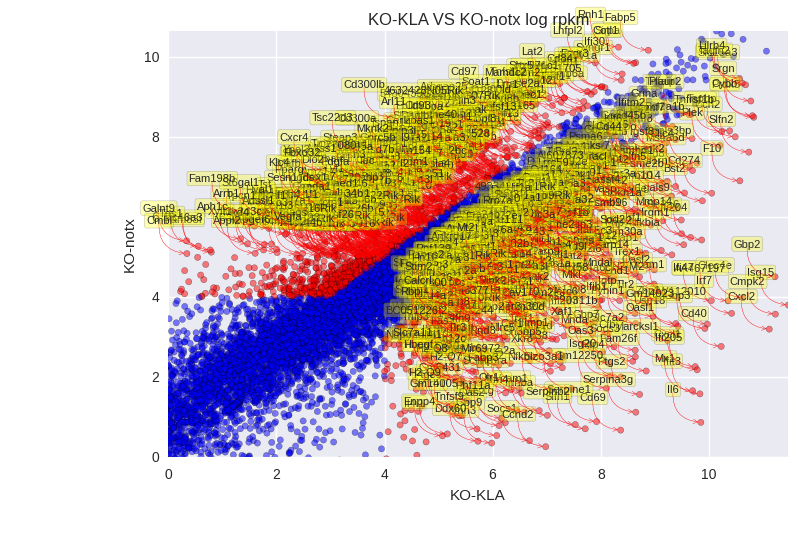

KO-KLA WT-KLA


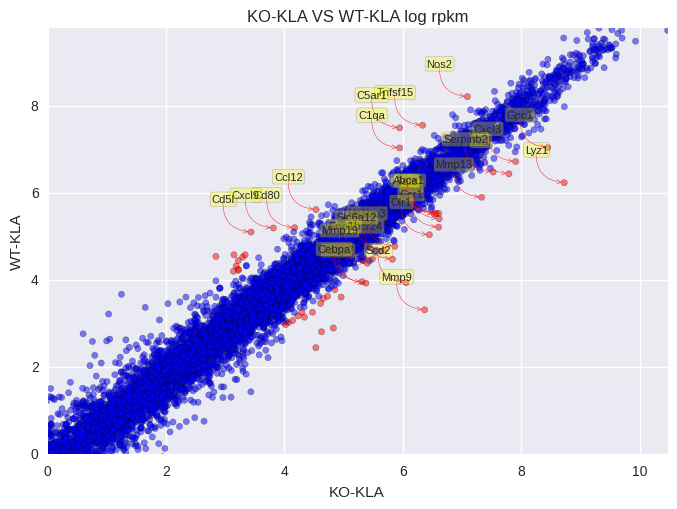

KO-KLA WT-notx


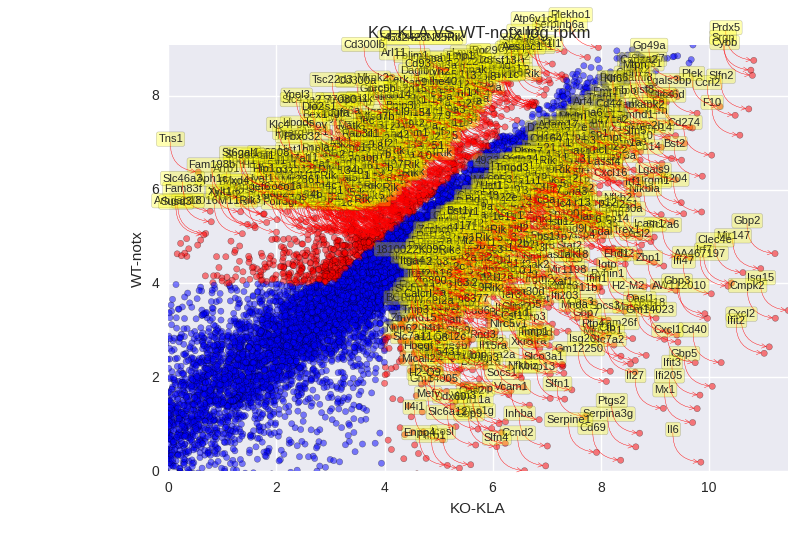

KO-notx WT-KLA


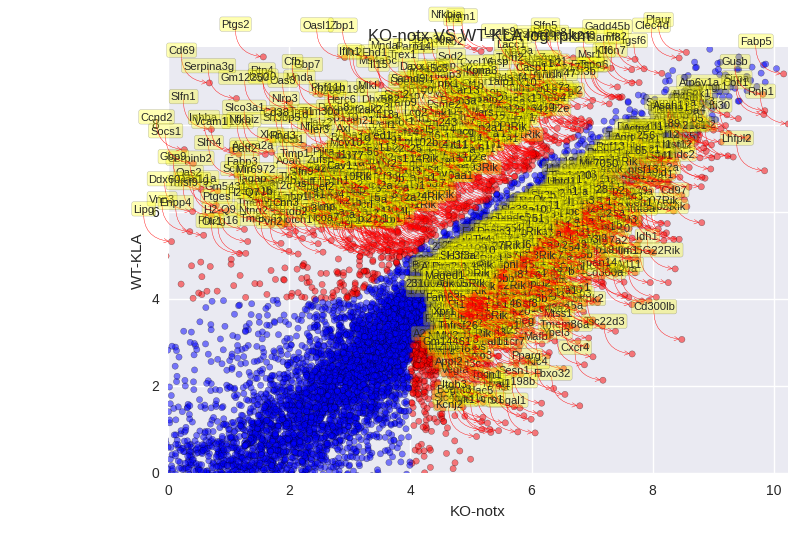

KO-notx WT-notx


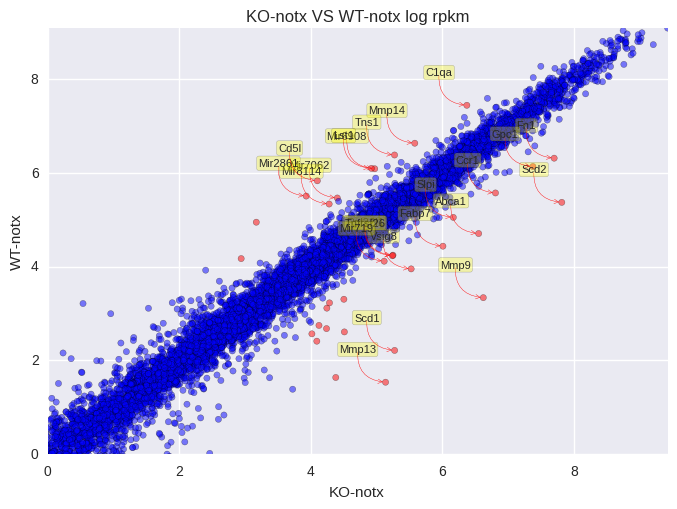

WT-KLA WT-notx


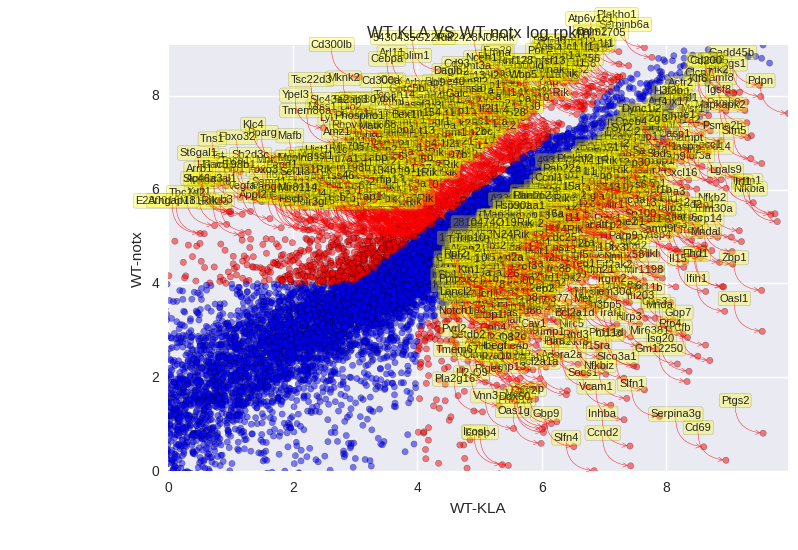

In [197]:
# %%capture
# plot meta scatter plots for different conditions
factor = 2.0
tagCutoff = 16.0

# for tag counts
treatments = sorted(list(set(list(filtered_summary_frame['strain'] + '-' + filtered_summary_frame['simpleTreatment']))))
seenTreatments = set()

! if [ ! -d ./scatter_plots ]; then mkdir ./scatter_plots; fi
for i in range(len(treatments) - 1):
    for j in range(i + 1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments [j]
        ! if [ ! -d ./scatter_plots/$treatment1_$treatment2 ]; then mkdir ./scatter_plots/$treatment1_$treatment2; fi

for i in range(len(treatments) - 1):
    for j in range(i + 1, len(treatments)):

        treatment1 = treatments[i]
        treatment2 = treatments [j]
        print(treatment1, treatment2)
        currentDir = "scatter_plots/" + treatment1 + "_" + treatment2
        altCurrentDir = "scatter_plots/" + treatment2 + "_" + treatment1
        if altCurrentDir in seenTreatments:
            currentDir = altCurrentDir
        if not currentDir in seenTreatments:
            if not os.path.isdir(currentDir):
                os.mkdir(currentDir)
            seenTreatments.add(currentDir)

        idrIntersection_frame_1 = pd.read_csv(idrDirectory + '/' +treatment1 + '_idrIntersection.tsv', sep='\t')
        intersecting_refseqs_1 = set(idrIntersection_frame_1['refseq'].values)
        idrIntersection_frame_2 = pd.read_csv(idrDirectory + '/' +treatment2 + '_idrIntersection.tsv', sep='\t')
        intersecting_refseqs_2 = set(idrIntersection_frame_2['refseq'].values)
        intersecting_refseqs = intersecting_refseqs_1.intersection(intersecting_refseqs_2)
        
        
        current_rpkm_frame = idrIntersection_frame_1.merge(idrIntersection_frame_2, on='refseq')
        current_rpkm_frame['gene'] = [refseq_gene_mapping[x] for x in current_rpkm_frame['refseq'].values]
        genes = current_rpkm_frame['gene'].values
        refseqs = current_rpkm_frame['refseq'].values

        read_list_1 = np.array([np.mean([float(y) for y in x.split(',')]) if ',' in x else float(x) for x in current_rpkm_frame['count_x'].astype(str)])
        read_list_2 = np.array([np.mean([float(y) for y in x.split(',')]) if ',' in x else float(x) for x in current_rpkm_frame['count_y'].astype(str)])
        log_read_list_1 = np.log2(read_list_1 + 0.00000001)
        log_read_list_2 = np.log2(read_list_2 + 0.00000001)

        coords = []
        labels = []
        colors = []
        fig, ax = plt.subplots()
        meta_geneList_up = []
        meta_geneList_down = []
        foldChanges = []
        for x in range(len(read_list_1)):
            foldChange = read_list_1[x]/read_list_2[x]
            if read_list_1[x] >= tagCutoff or read_list_2[x] >= tagCutoff:
                if foldChange >= factor or foldChange <= 1.0/factor:
                    if read_list_1[x] >= 2 * tagCutoff or read_list_2[x] >=  2 * tagCutoff:
                        labels.append(genes[x])
                        if foldChange >= factor:
                            foldChanges.append(foldChange)
                            meta_geneList_up.append(refseqs[x])
                        if foldChange <= 1.0/factor:
                            foldChanges.append(-1.0/foldChange)
                            meta_geneList_down.append(refseqs[x])
                        coords.append((log_read_list_1[x],log_read_list_2[x]))
                    colors.append('red')
                else:
                    colors.append('blue')
            else:
                colors.append('blue')
        plt.scatter(log_read_list_1,log_read_list_2, c= colors, alpha = 0.5);
        plt.xlabel(treatment1)
        plt.ylabel(treatment2)
        plt.title(treatment1 + " VS " + treatment2 + " log rpkm")
        plt.ylim(0,max(log_read_list_2))
        plt.xlim(0,max(log_read_list_1))
        for x in range(len(coords)):
            gene = labels[x]
            ax.annotate(gene, xy=coords[x], xytext=(-20,20), size=8,
                    textcoords='offset points', ha='center', va='bottom',
                    bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))
        plt.savefig(workingDirectory + "/" + currentDir + "/" +treatment1 + '_' + treatment2 + "_merged_log.pdf")
        plt.show()
     
        
        
        

## Plot Hyporesponsive and Derepressed Genes

In [416]:

wt_kla_vs_wt_veh_up_genes = diffExpression_frame[(diffExpression_frame['WT-KLA vs. WT-notx logFC'] < 0) &
                                         (diffExpression_frame['WT-KLA vs. WT-notx PValue'] < 0.01) &
                                         (diffExpression_frame['WT-KLA vs. WT-notx FDR'] < 0.05)]
ko_kla_vs_wt_kla_down_genes= diffExpression_frame[(diffExpression_frame['KO-KLA vs. WT-KLA logFC'] > 0) &
                                         (diffExpression_frame['KO-KLA vs. WT-KLA PValue'] <0.01) &
                                         (diffExpression_frame['KO-KLA vs. WT-KLA FDR'] <0.05)]
hyporesponsive_genes = set(wt_kla_vs_wt_veh_up_genes.index).intersection(ko_kla_vs_wt_kla_down_genes.index)
derepressed_genes = diffExpression_frame[(diffExpression_frame['KO-notx vs. WT-notx logFC'] < 0) &
                                         (diffExpression_frame['KO-notx vs. WT-notx PValue'] <0.01) &
                                         (diffExpression_frame['KO-notx vs. WT-notx FDR'] <0.05)].index.values
print("number of hyporesponsive genes", len(hyporesponsive_genes))
print("number of derepressed genes", len(derepressed_genes))

number of hyporesponsive genes 125
number of derepressed genes 97


In [466]:
# create frame that's easier to use with factor plots
refseq_gene_mapping = dict(zip(raw_frame['refseq'].values, 
                               [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]))
raw_frame.index = raw_frame['refseq'].values
pivoting_frame = raw_frame.ix[:,9:].transpose()
_refseq = []
_gene = []
_reads = []
_simplifiedName = list(pivoting_frame.index.values) * pivoting_frame.shape[1]
_treatment = list(filtered_summary_frame['strain'].values + '-' + filtered_summary_frame['simpleTreatment'].values) * pivoting_frame.shape[1]

for refseq in pivoting_frame.columns:
    gene = refseq_gene_mapping[refseq]
    for read in pivoting_frame[refseq].values:
        _reads.append(read)
        _refseq.append(refseq)
        _gene.append(gene)
raw_plottingFrame = pd.DataFrame({
'refseq': _refseq,
'gene': _gene, 
'reads': _reads,
'simplifiedName': _simplifiedName,
'treatment': _treatment
})
raw_plottingFrame['genotype'] = [x.split('-')[0] for x in raw_plottingFrame['treatment']]


In [500]:
filtered_rpkm_plottingFrame['genotype'] = [x.split('-')[0] for x in filtered_rpkm_plottingFrame['treatment']]



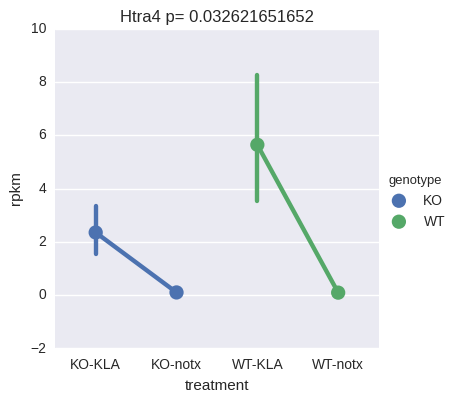

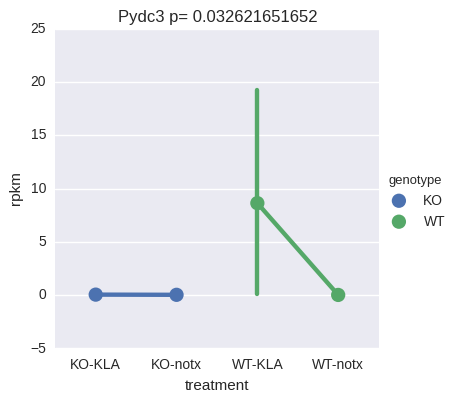

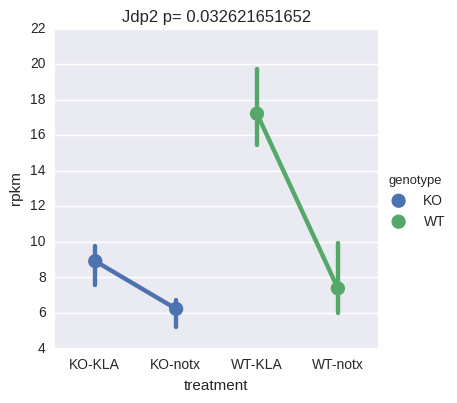

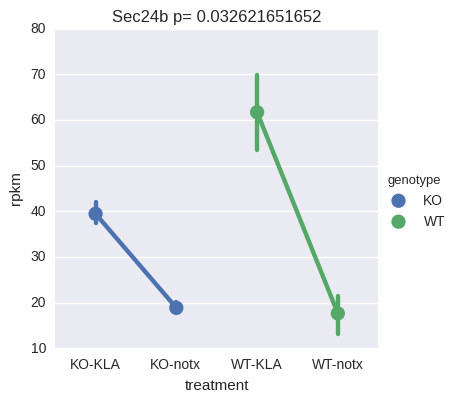

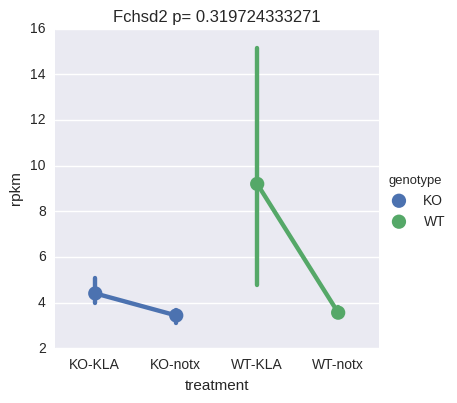

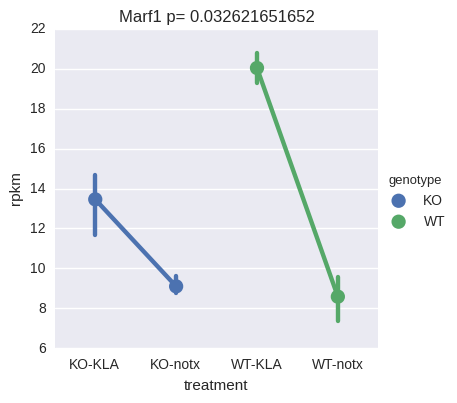

In [ ]:
refseq_gene_mapping = dict(zip(diffExpression_frame['refseq'].values, 
                               [x.split("|")[0] for x in diffExpression_frame['Divergence']]))
genes = set(filtered_rpkm_plottingFrame['gene'].values)
for refseq in hyporesponsive_genes:
    gene = refseq_gene_mapping[refseq]
    if gene in genes:
        data = filtered_rpkm_plottingFrame[filtered_rpkm_plottingFrame['gene']==gene]
        wt_kla_reads = data[data['treatment'] == 'WT-KLA']['rpkm'].values
        ko_kla_reads = data[data['treatment'] == 'KO-KLA']['rpkm'].values
        D, pval = stats.ks_2samp(wt_kla_reads,ko_kla_reads)
        sns.factorplot(x='treatment',y='rpkm', data = data, kind='point',hue='genotype')
        plt.title(gene + ' p= ' + str(pval))
        plt.savefig(gene+'_hyporesponsive.png')
        plt.show()
    else:
        print('missing gene! ', gene)
    

## H3K4me3 Stuff

In [72]:
idr_rpkm_frame.to_csv('idr_rpkm_peaks.tsv',sep='\t', index=False)



In [75]:
# annotated genes with h3k4me3
!annotatePeaks.pl /home/jenhan/analysis/ncor_analysis/idr_rpkm_peaks.tsv mm10 -size 2000 -d tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_15_02_02/ tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_KLA_1h_JSS_14_11_04 tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_15_02_02 tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_NoTx_JSS_14_11_04 tag_directories_enhancerMarks/BMDM_NCoR*H3K4me3* > rpkm_h3k4me3_annotated_peaks.tsv


	Peak file = /home/jenhan/analysis/ncor_analysis/idr_rpkm_peaks.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 2000
	Tag Directories:
		tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_KLA_1h_JSS_15_02_02/
		tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_KLA_1h_JSS_14_11_04
		tag_directories_chip/Sample_Coro2AWT_BMDM_ChIP_NCoR_NoTx_JSS_15_02_02
		tag_directories_chip/Sample_NCoRWT_BMDM_NCoR_NoTx_JSS_14_11_04
		tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K4me3_KLA-1h_Josh_14-07-07
		tag_directories_enhancerMarks/BMDM_NCoR-KO_ChIP_H3K4me3_Veh-1h_Josh_14-07-07
		tag_directories_enhancerMarks/BMDM_NCoR-WT_ChIP_H3K4me3_KLA-1h_Josh_14-07-07
		tag_directories_enhancerMarks/BMDM_NCoR-WT_ChIP_H3K4me3_Veh-1h_Josh_14-07-07
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 10516
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 10516
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)

In [76]:
annotated_peak_frame = pd.read_csv('rpkm_h3k4me3_annotated_peaks.tsv', sep='\t')
rpkm_peaks_frame = pd.read_csv('idr_rpkm_peaks.tsv', sep='\t')


columns = annotated_peak_frame.columns.values
columns[0] = 'gene'
annotated_peak_frame.columns = columns

rpkm_peaks_frame['NCoR_WT_KLA_ChIP'] = np.mean(annotated_peak_frame.ix[:,[-8,-7]], axis=1)
rpkm_peaks_frame['NCoR_WT_notx_ChIP'] = np.mean(annotated_peak_frame.ix[:,[-6,-5]], axis=1)
rpkm_peaks_frame['NCoR_KO_H3K4me3_KLA'] = annotated_peak_frame.ix[:,-4]
rpkm_peaks_frame['NCoR_KO_H3K4me3_notx'] = annotated_peak_frame.ix[:,-3]
rpkm_peaks_frame['NCoR_WT_H3K4me3_KLA'] = annotated_peak_frame.ix[:,-2]
rpkm_peaks_frame['NCoR_WT_H3K4me3_notx'] = annotated_peak_frame.ix[:,-1]




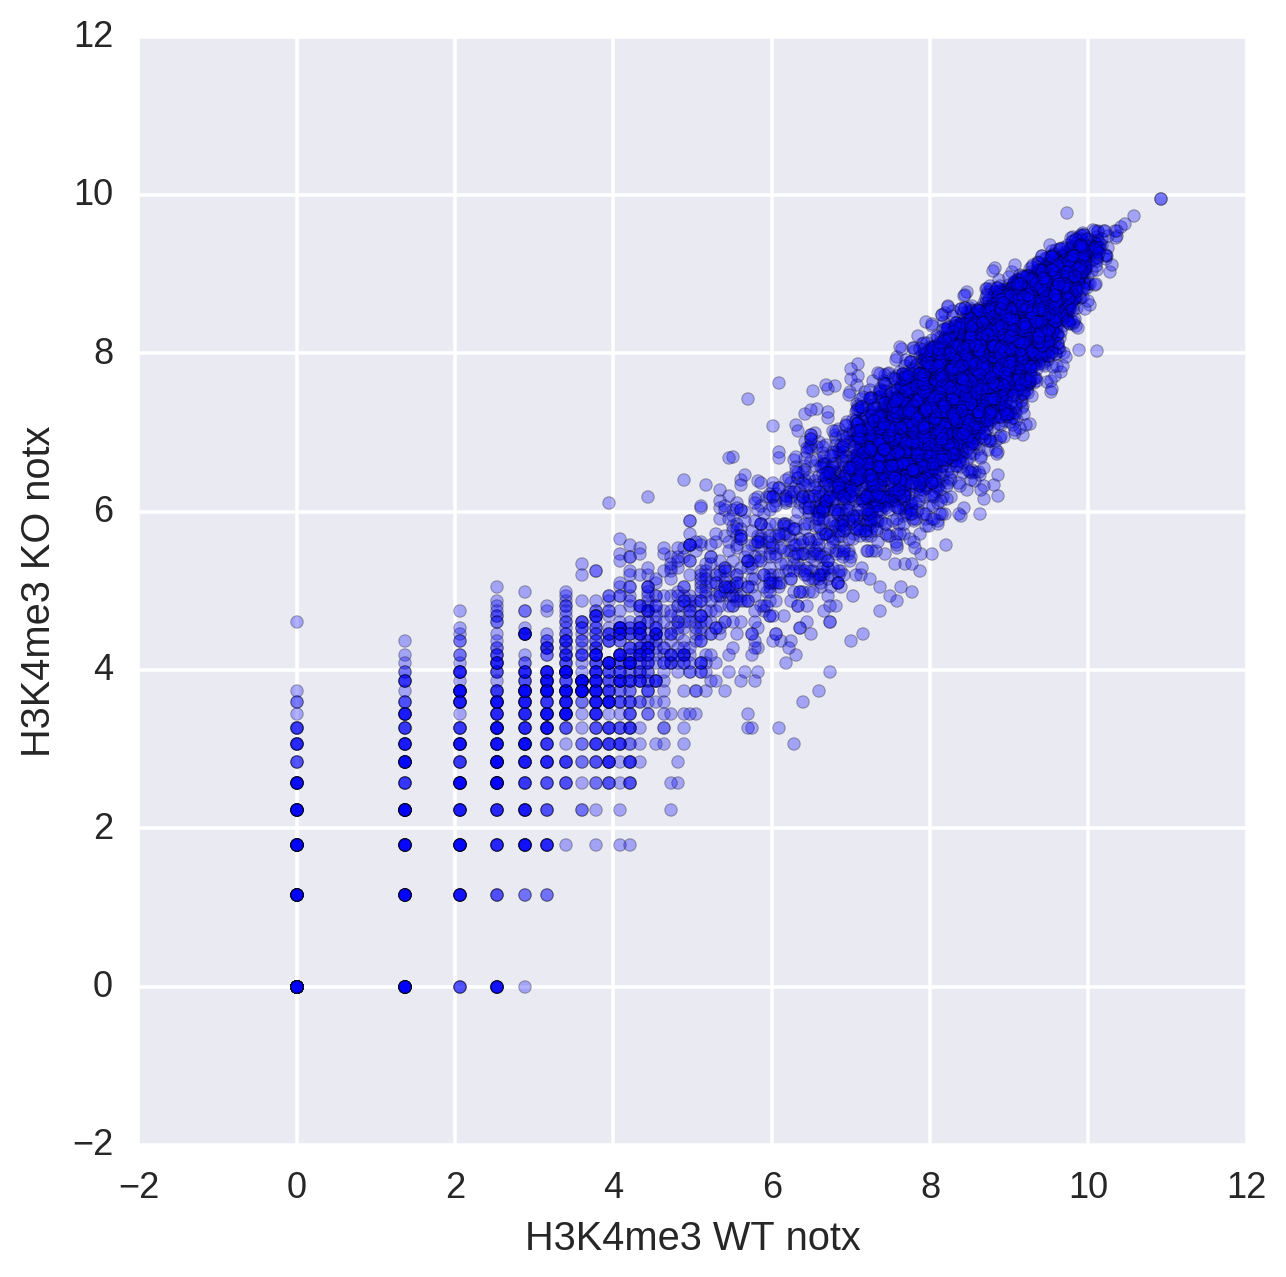

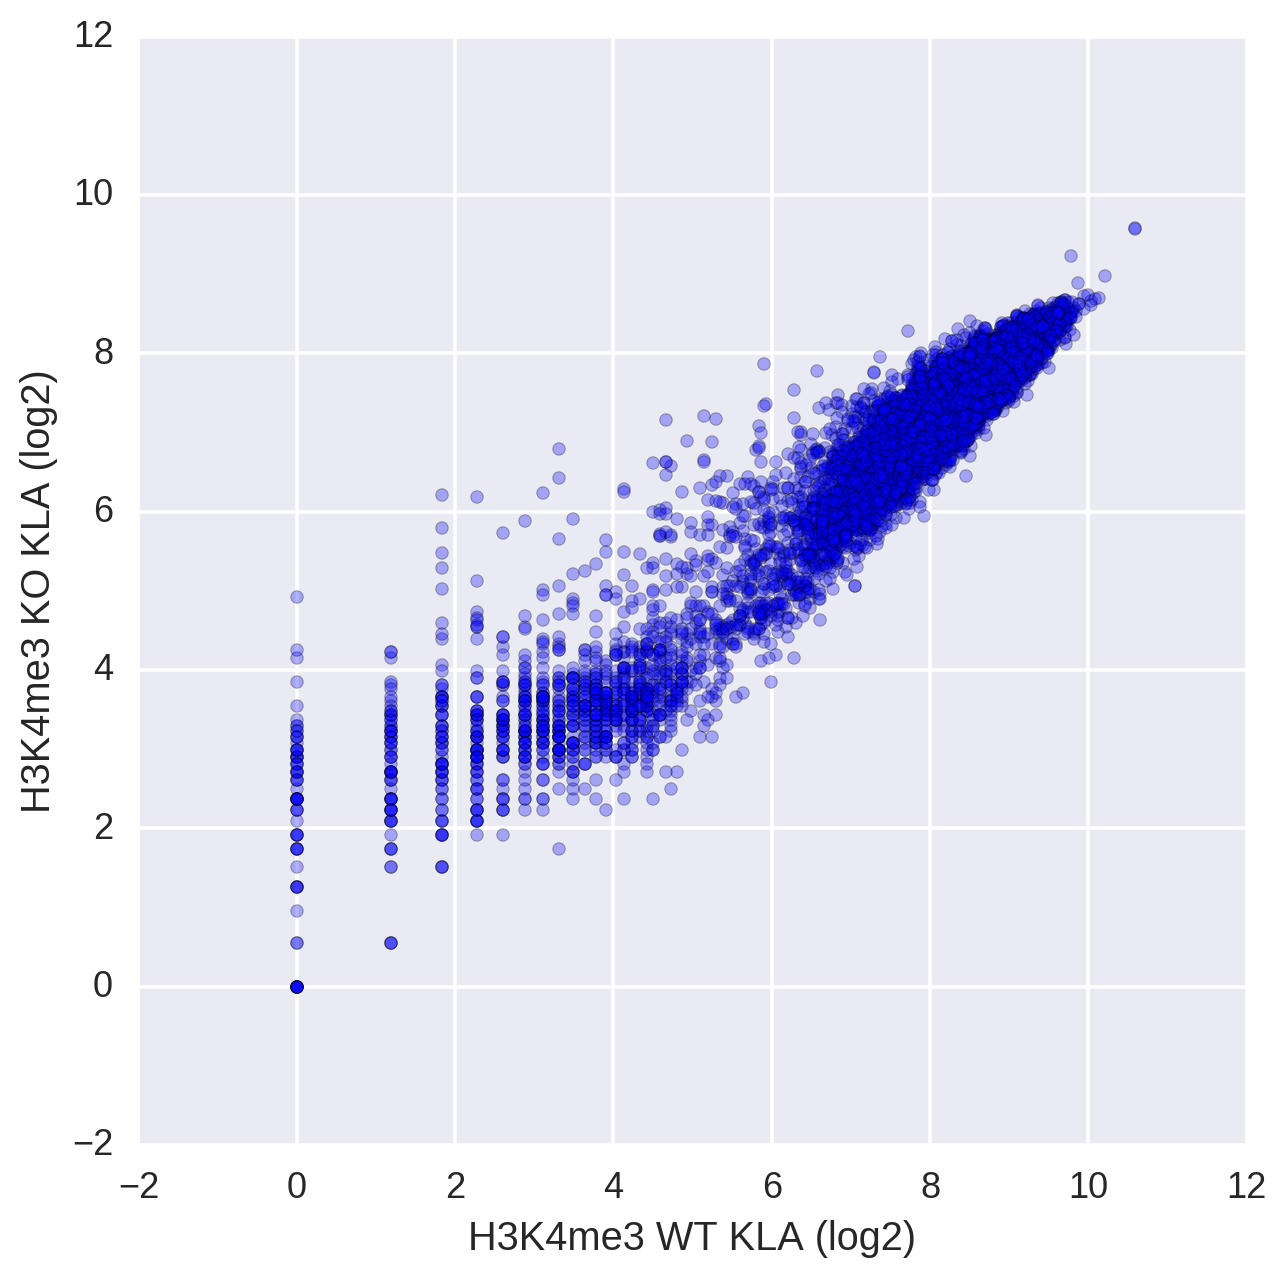

In [141]:
plt.scatter(np.log2(rpkm_peaks_frame['NCoR_WT_H3K4me3_notx']+1), np.log2(rpkm_peaks_frame['NCoR_KO_H3K4me3_notx']+1), 
            alpha=0.3)
plt.axes().set_aspect('equal')
# plt.xlim([0,10])
# plt.ylim([0,10])
# plt.plot([0,10], [0,10])
plt.xlabel('H3K4me3 WT notx')
plt.ylabel('H3K4me3 KO notx')
plt.show()
plt.scatter(np.log2(rpkm_peaks_frame['NCoR_WT_H3K4me3_KLA']+1), np.log2(rpkm_peaks_frame['NCoR_KO_H3K4me3_KLA']+1), 
            alpha=0.3)
plt.axes().set_aspect('equal')
# plt.xlim([0,10])
# plt.ylim([0,10])
# plt.plot([0,10], [0,10])
plt.xlabel('H3K4me3 WT KLA (log2)')
plt.ylabel('H3K4me3 KO KLA (log2)')

141


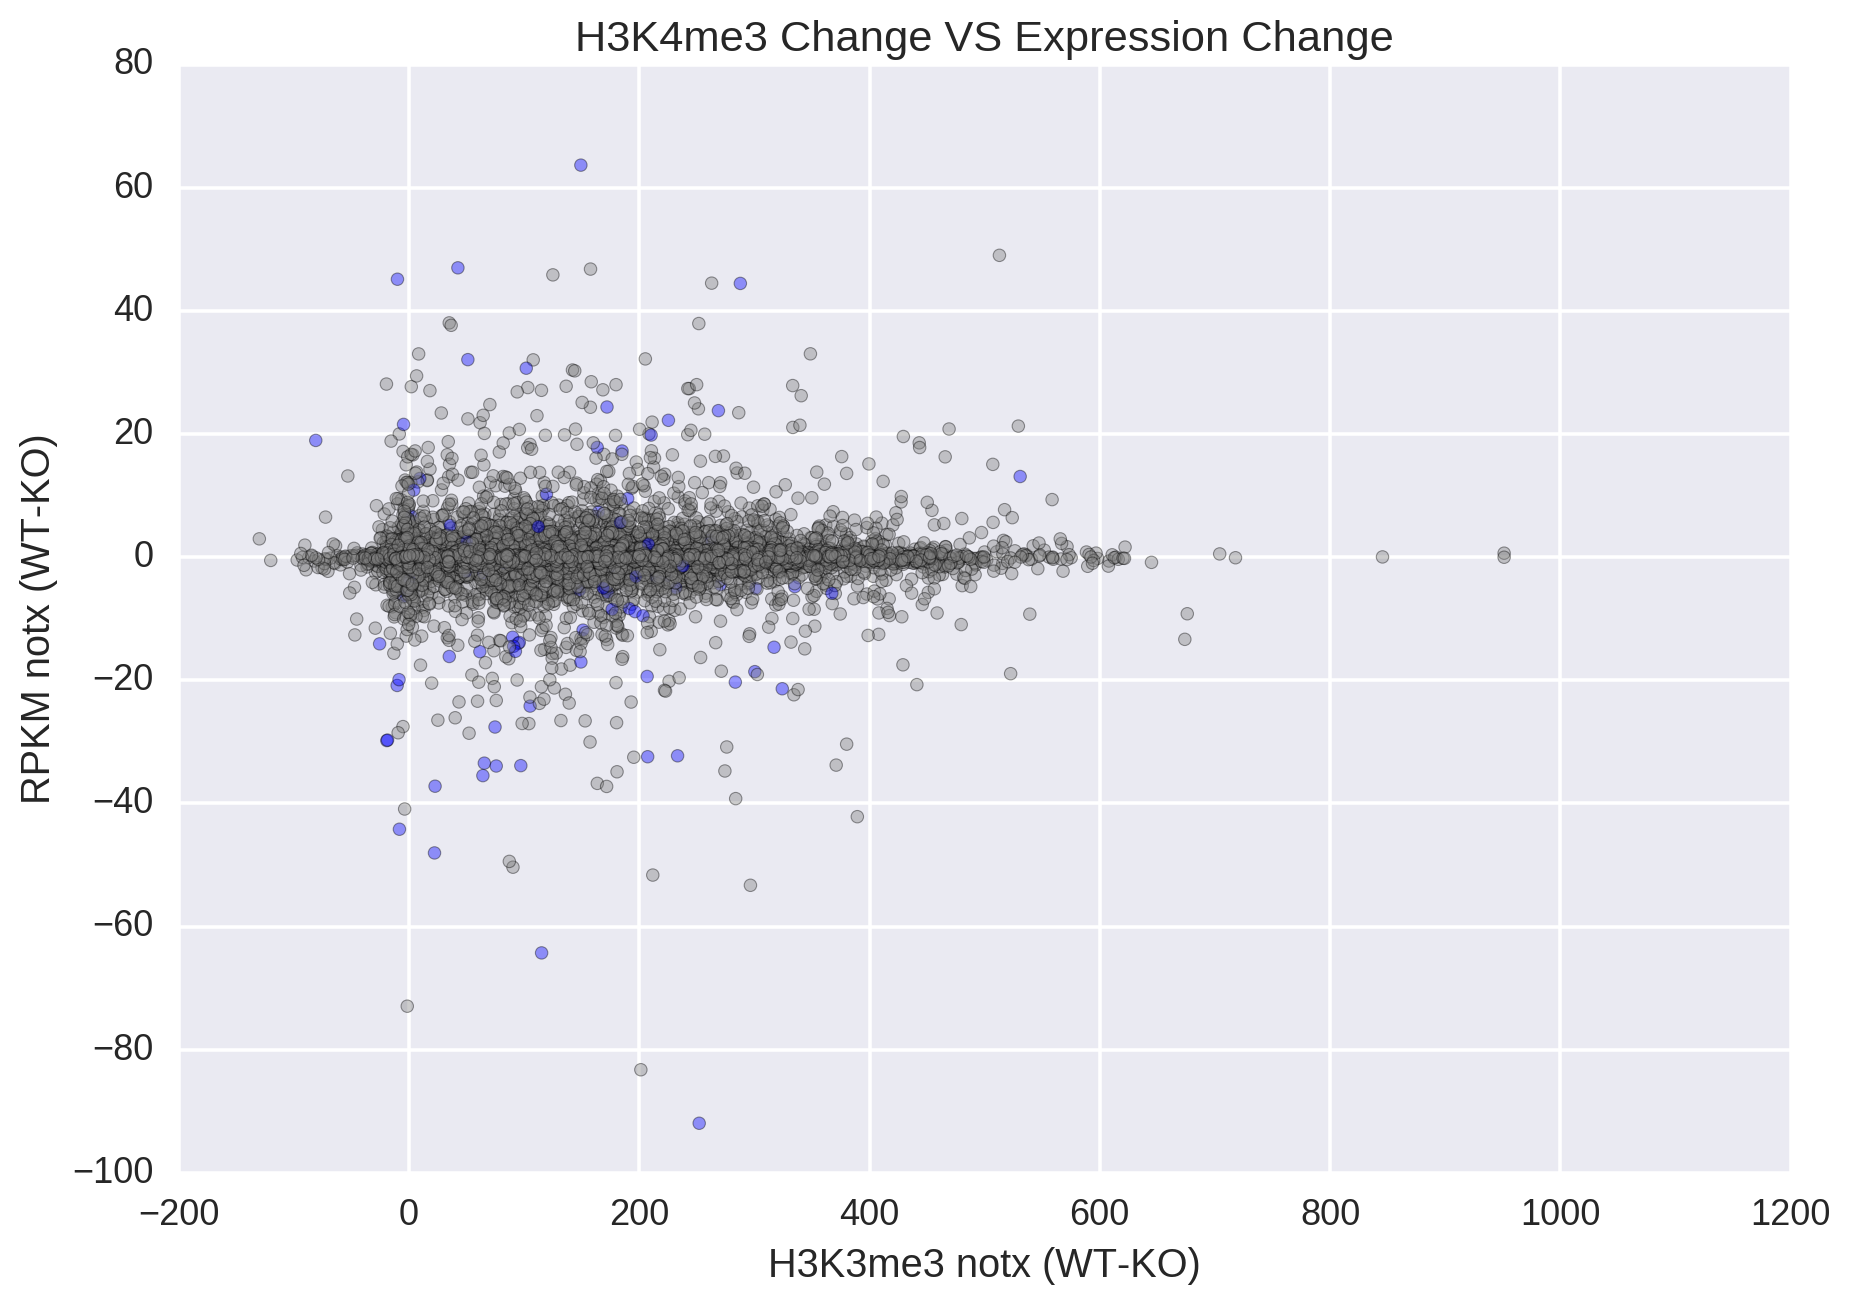

In [117]:
diffExpressedGenes = diffExpression_frame[diffExpression_frame['KO-notx vs. WT-notx FDR'] <0.05]['gene'].values
print(len(diffExpressedGenes))

colors = []
genes = rpkm_peaks_frame['gene'].values
for g in genes:
    if g in diffExpressedGenes:
            colors.append('blue')
    else:
        colors.append('grey')
 
                
plt.scatter(rpkm_peaks_frame['NCoR_WT_H3K4me3_notx'] - rpkm_peaks_frame['NCoR_KO_H3K4me3_notx'],
        rpkm_peaks_frame['WT_notx'] - rpkm_peaks_frame['KO_notx'],
           alpha=0.4,
           c=colors)
plt.xlabel('H3K3me3 notx (WT-KO)')
plt.ylabel('RPKM notx (WT-KO)')
plt.title('H3K4me3 Change VS Expression Change')

244


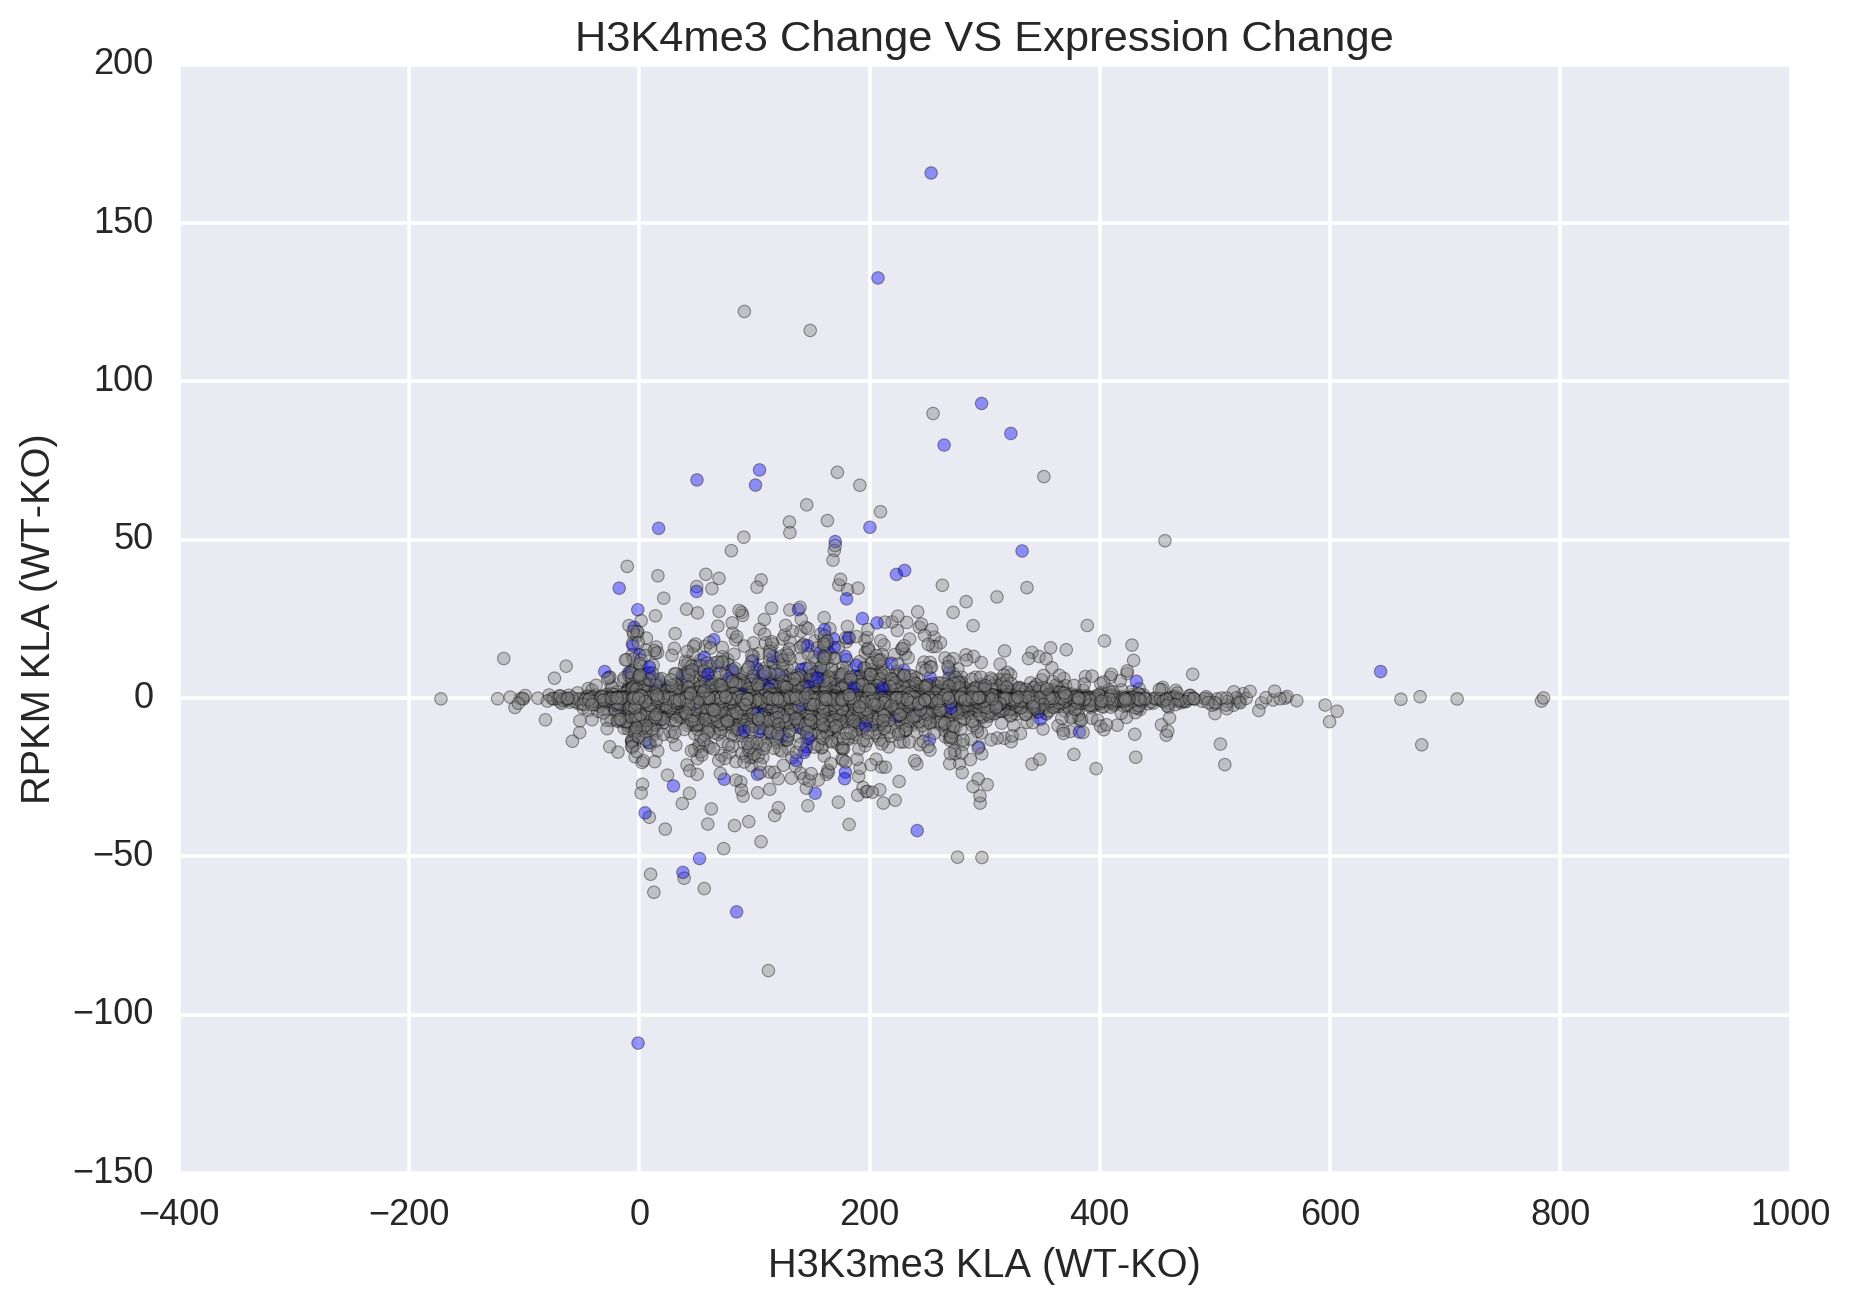

In [116]:
diffExpressedGenes = diffExpression_frame[diffExpression_frame['KO-KLA vs. WT-KLA FDR'] <0.05]['gene'].values
print(len(diffExpressedGenes))

colors = []
genes = rpkm_peaks_frame['gene'].values
for g in genes:
    if g in diffExpressedGenes:
            colors.append('blue')
    else:
        colors.append('grey')

plt.scatter(rpkm_peaks_frame['NCoR_WT_H3K4me3_KLA'] - rpkm_peaks_frame['NCoR_KO_H3K4me3_KLA'],
            rpkm_peaks_frame['WT_KLA'] - rpkm_peaks_frame['KO_KLA'],
           alpha=0.4,
           c=colors)
plt.xlabel('H3K3me3 KLA (WT-KO)')
plt.ylabel('RPKM KLA (WT-KO)')
plt.title('H3K4me3 Change VS Expression Change')

## Gene Ontology Analysis

In [134]:
KLA_genes = diffExpression_frame[diffExpression_frame['KO-KLA vs. WT-KLA FDR'] <0.05]['gene'].values
out_file = open('kla_diffExpressedGenes.txt', 'w')
for g in KLA_genes:
    out_file.write(g + '\n')
out_file.close()

notx_genes = diffExpression_frame[diffExpression_frame['KO-notx vs. WT-notx FDR'] <0.05]['gene'].values
out_file = open('notx_diffExpressedGenes.txt', 'w')
for g in notx_genes:
    out_file.write(g + '\n')
out_file.close()

background_genes = idr_rpkm_frame['gene']
out_file = open('backgroundGenes.txt', 'w')
for g in background_genes:
    out_file.write(g + '\n')
out_file.close()


In [135]:
!/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py kla_diffExpressedGenes.txt backgroundGenes.txt /home/jenhan/analysis/go_analysis/mouse_association --fdr --pval=0.5 > kla_results.tsv
!/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py notx_diffExpressedGenes.txt backgroundGenes.txt /home/jenhan/analysis/go_analysis/mouse_association --fdr --pval=0.5 > notx_results.tsv

Study: 244 vs. Population 10516


load obo file go-basic.obo
45896 nodes imported
Propagating term counts to parents ..
Generate p-value distribution for FDR based on resampling (this might take a while)
Sample 0 / 500: p-value 0.131415890979
Sample 10 / 500: p-value 0.110773588205
Sample 20 / 500: p-value 0.296986931107
Sample 30 / 500: p-value 1
Sample 40 / 500: p-value 0.023202738684
Sample 50 / 500: p-value 1
Sample 60 / 500: p-value 1
Sample 70 / 500: p-value 1
Sample 80 / 500: p-value 1
Sample 90 / 500: p-value 0.023202738684
Sample 100 / 500: p-value 0.023202738684
Sample 110 / 500: p-value 1
Sample 120 / 500: p-value 0.023202738684
Sample 130 / 500: p-value 0.227684457538
Sample 140 / 500: p-value 0.227684457538
Sample 150 / 500: p-value 0.023202738684
Sample 160 / 500: p-value 0.296986931107
Sample 170 / 500: p-value 1
Sample 180 / 500: p-value 0.0458692657176
Sample 190 / 500: p-value 1
Sample 200 / 500: p-value 1
Sample 210 / 500: p-value 0.023202738684
Sample 220 / 500: p-v

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:3025: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


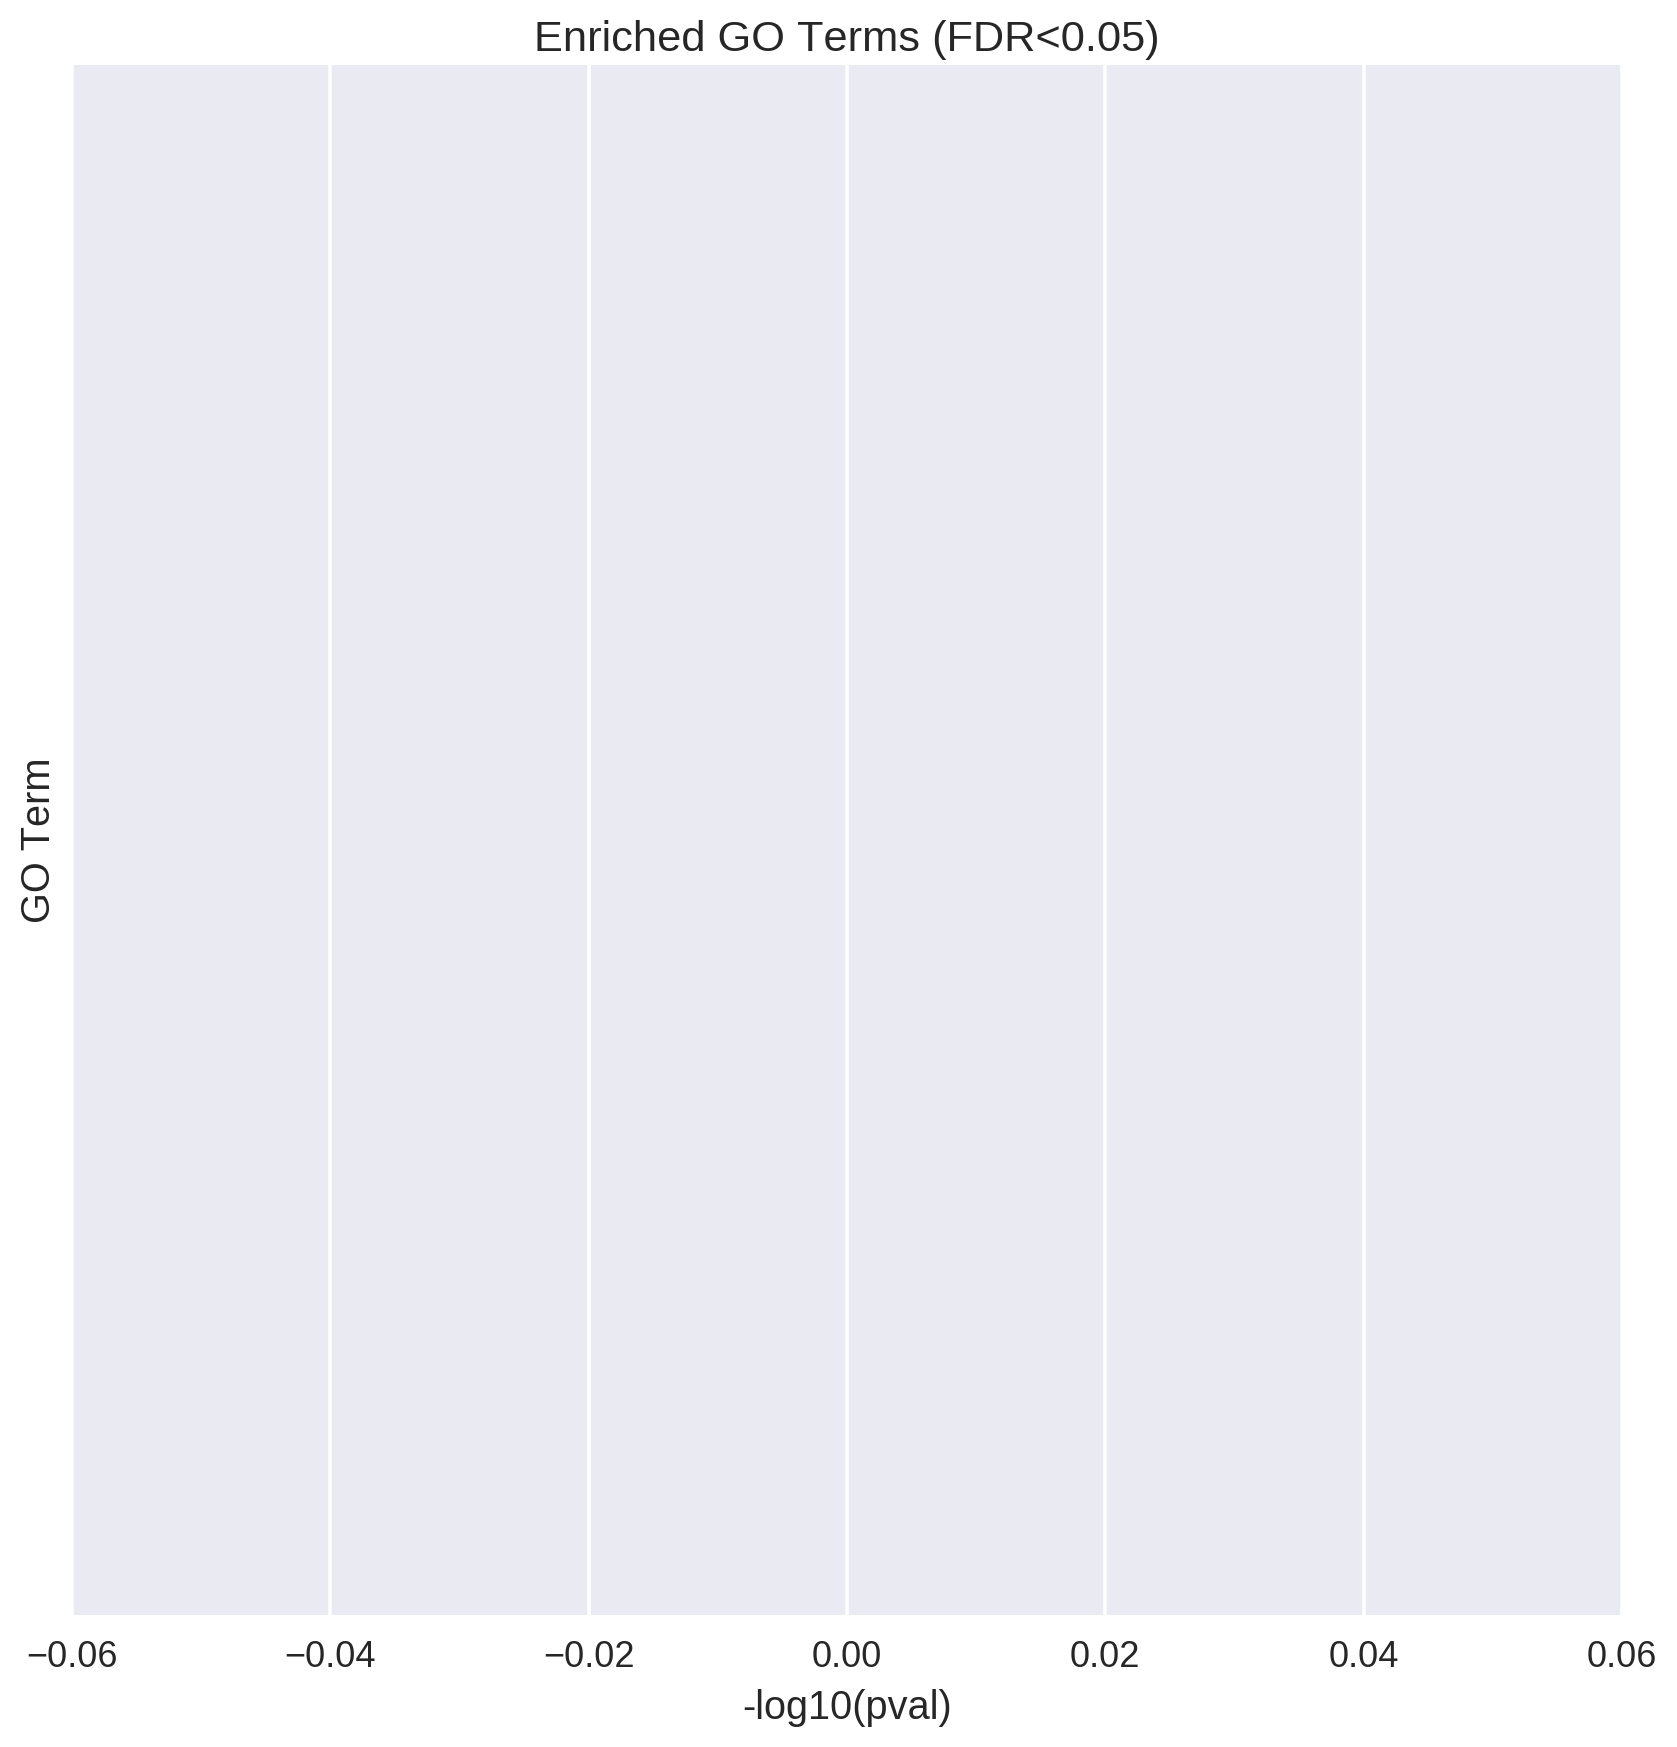

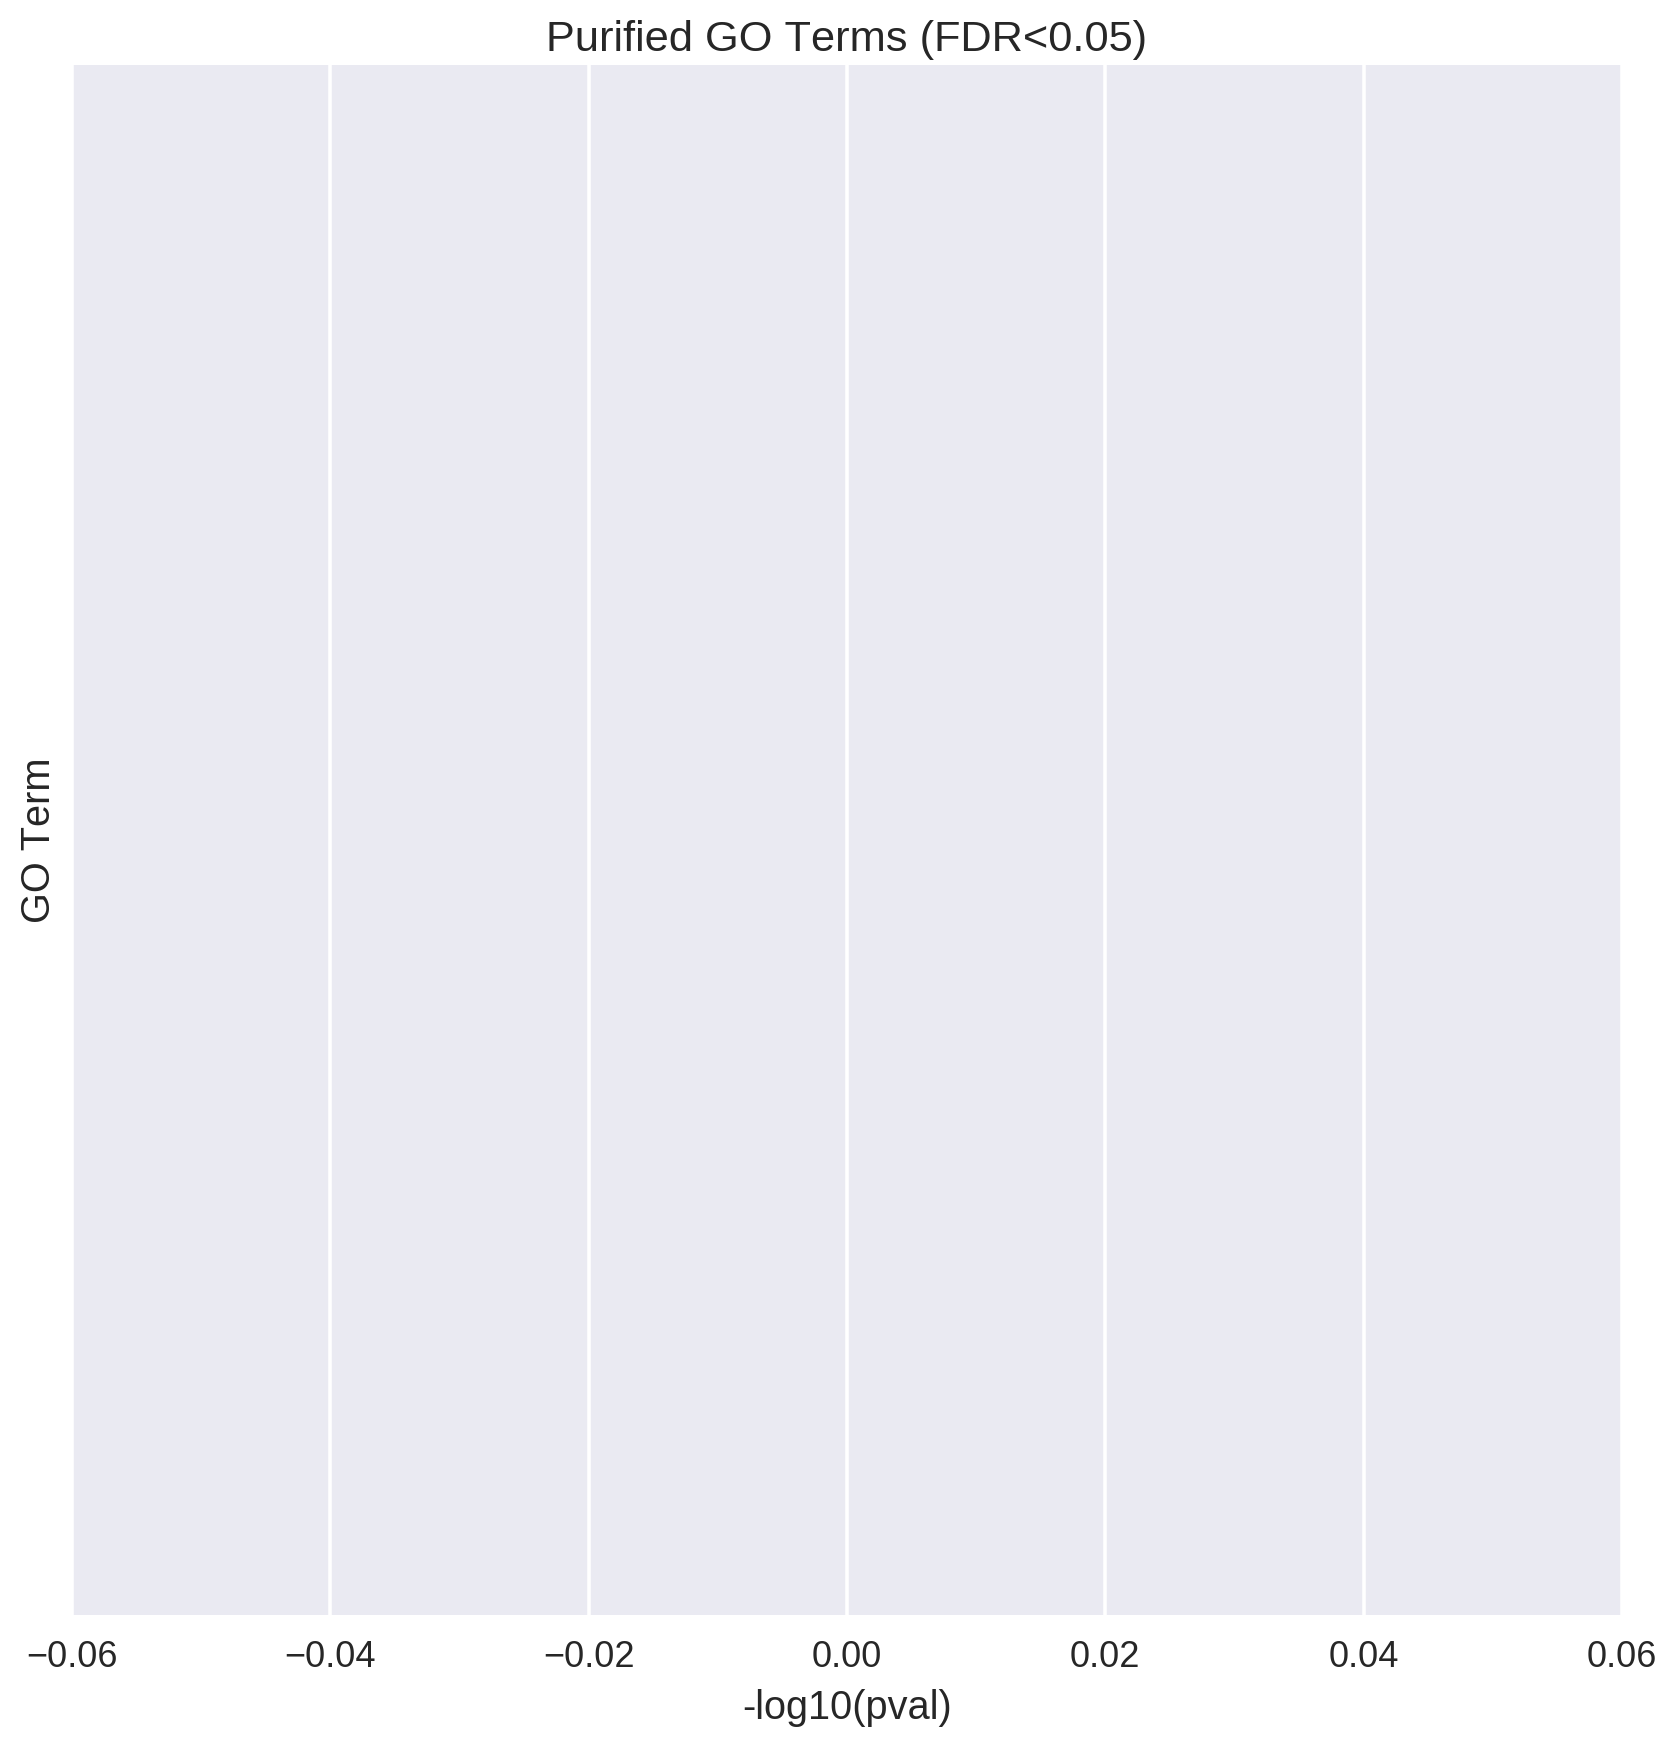

In [139]:
results = pd.read_csv('kla_results.tsv',sep='\t', skiprows=2)

maxTerms = 20
fdr_threshold = 0.05
significant_results = results[results['p_fdr'] < fdr_threshold]

# seperate enriched and purified results
enriched_results = significant_results[significant_results['enrichment']=='e']
purified_results= significant_results[significant_results['enrichment']=='p']

# plot enriched results
numTerms = np.min([maxTerms, enriched_results.shape[0]])
plt.figure(figsize = (10,10))
plt.barh(range(numTerms), 
         -1*np.log10(enriched_results.head(numTerms)['p_uncorrected']), 
         height=0.5,
       )
plt.yticks(np.arange(numTerms)+0.25, 
           enriched_results.head(numTerms)['description'], 
           fontsize=10)
plt.ylim([0, numTerms])
plt.ylabel('GO Term')
plt.xlabel('-log10(pval)')
plt.title('Enriched GO Terms (FDR<' + str(fdr_threshold) + ')')
plt.show()

# plot purified results
numTerms = np.min([maxTerms, purified_results.shape[0]])

plt.figure(figsize = (10,10))
plt.barh(range(numTerms), 
         -1*np.log10(purified_results.head(numTerms)['p_uncorrected']), 
         height=0.5,
       )
plt.yticks(np.arange(numTerms)+0.25, 
           purified_results.head(numTerms)['description'], 
           fontsize=10)
plt.ylim([0, numTerms])
plt.ylabel('GO Term')
plt.xlabel('-log10(pval)')
plt.title('Purified GO Terms (FDR<' + str(fdr_threshold) + ')')
plt.show()

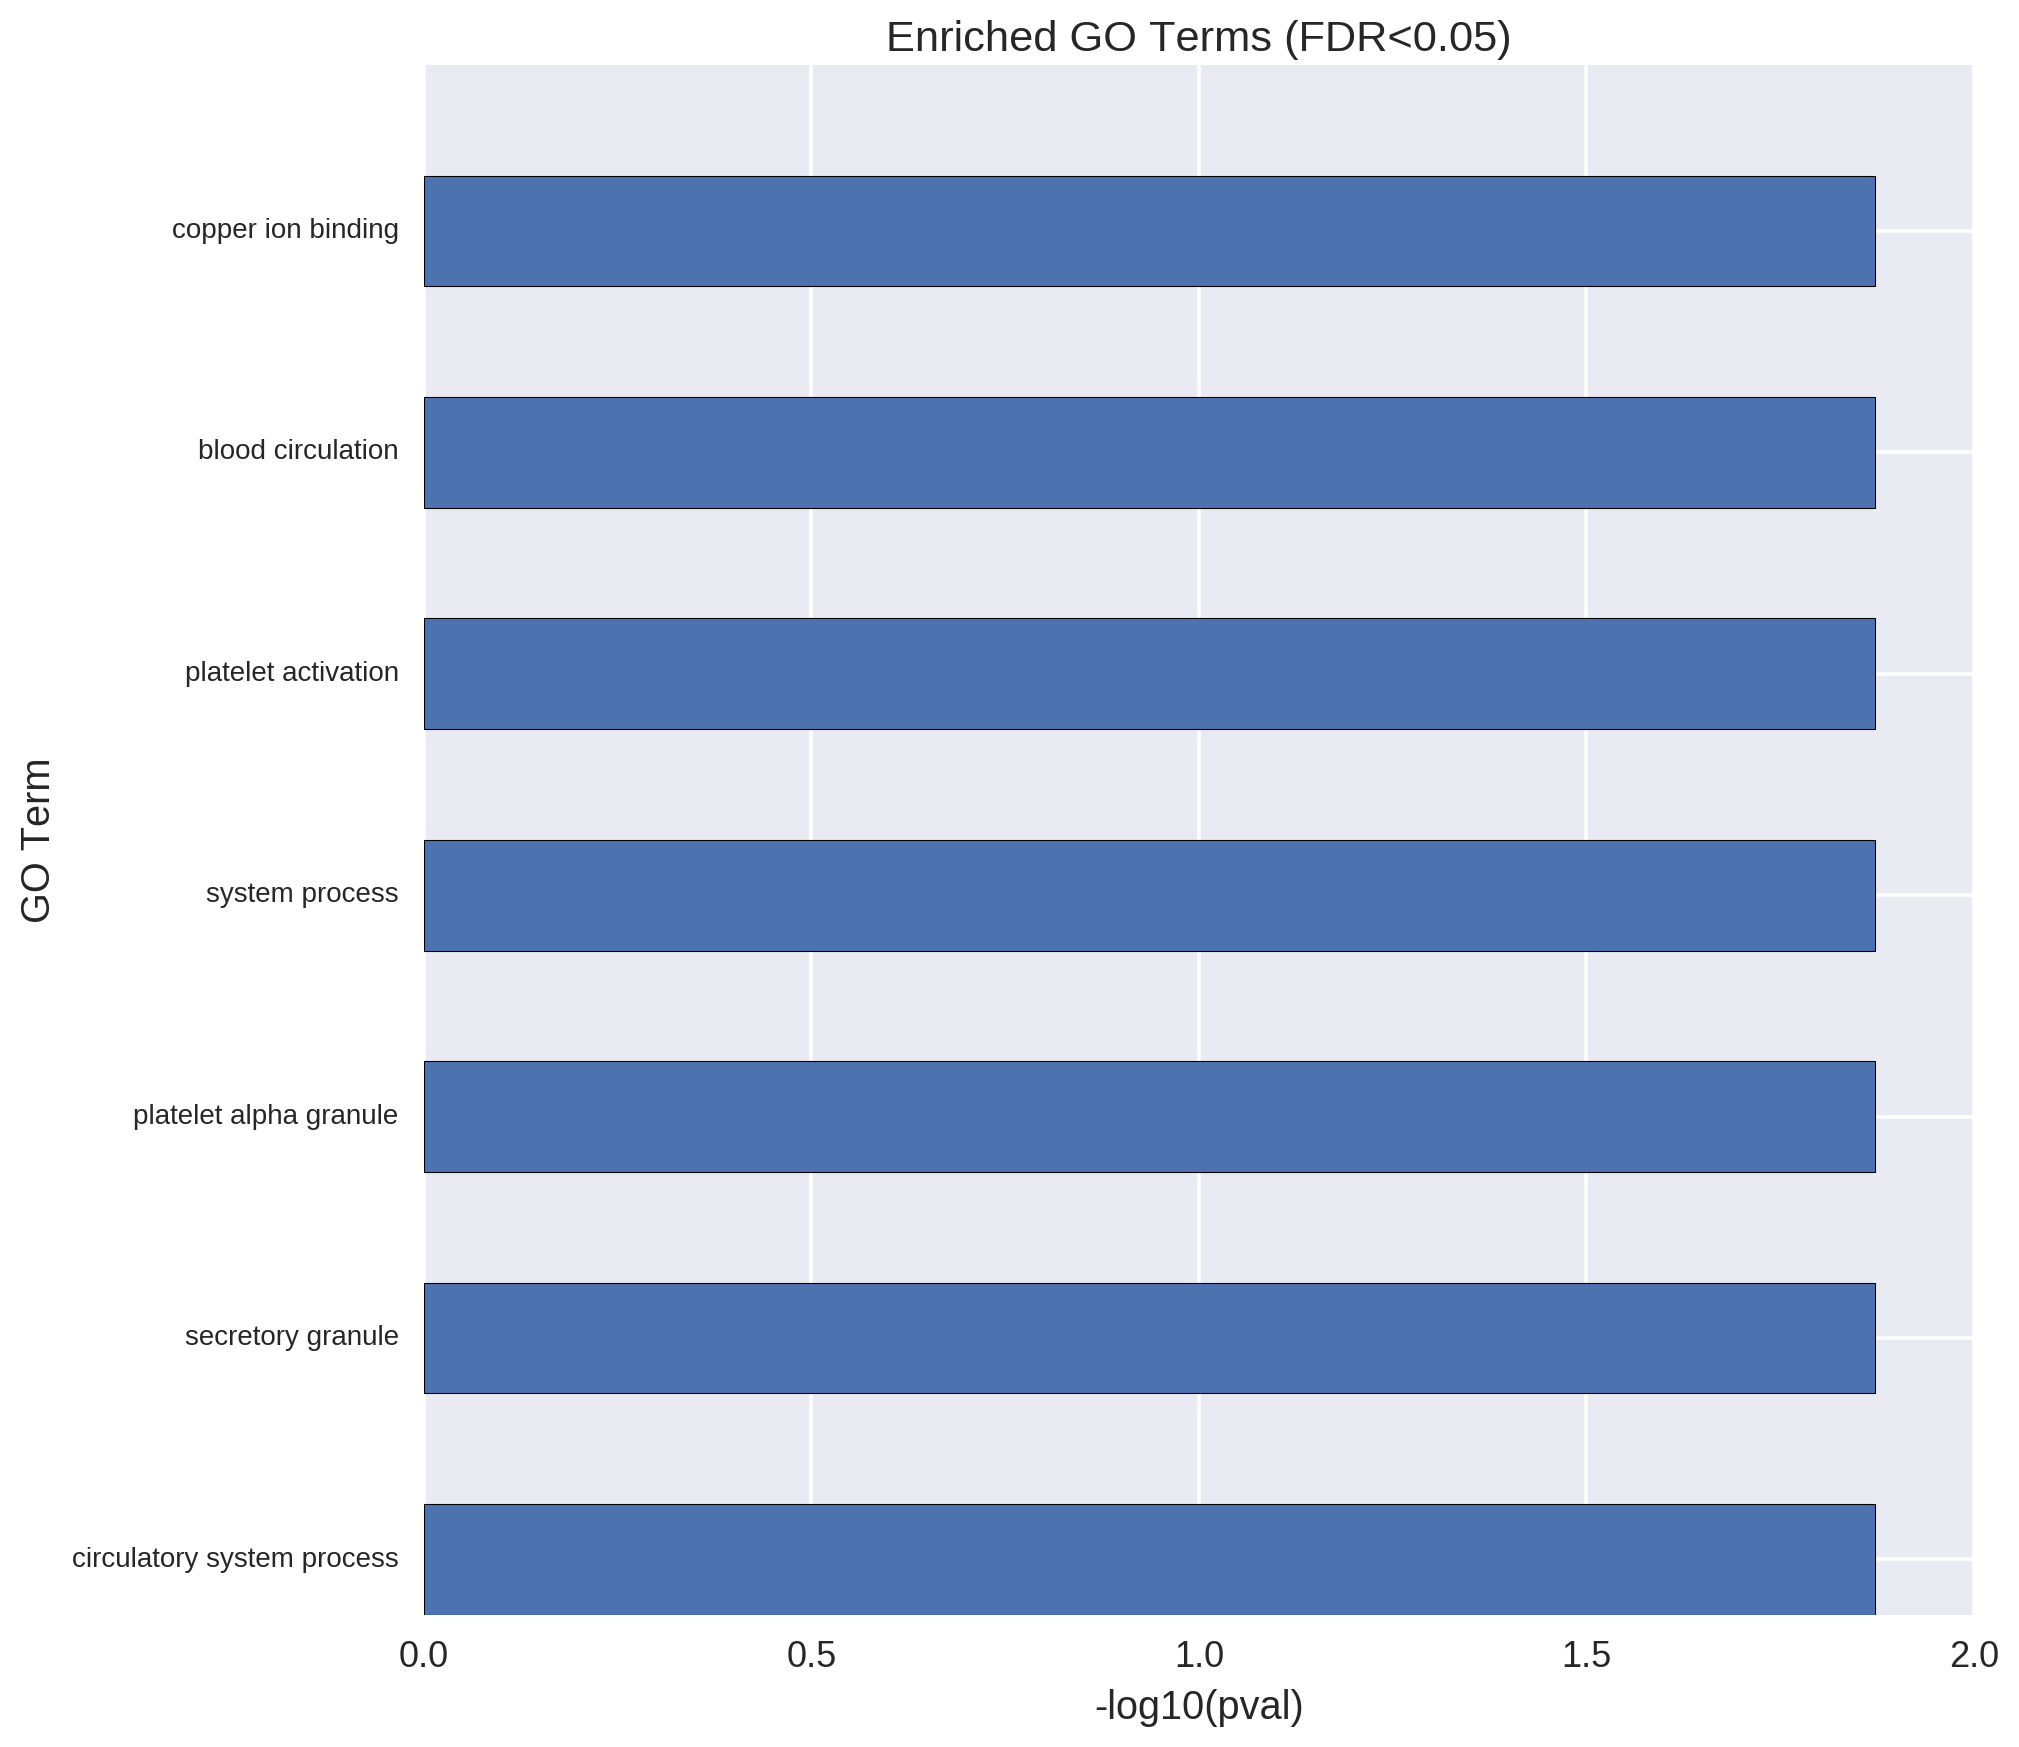

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:3025: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))


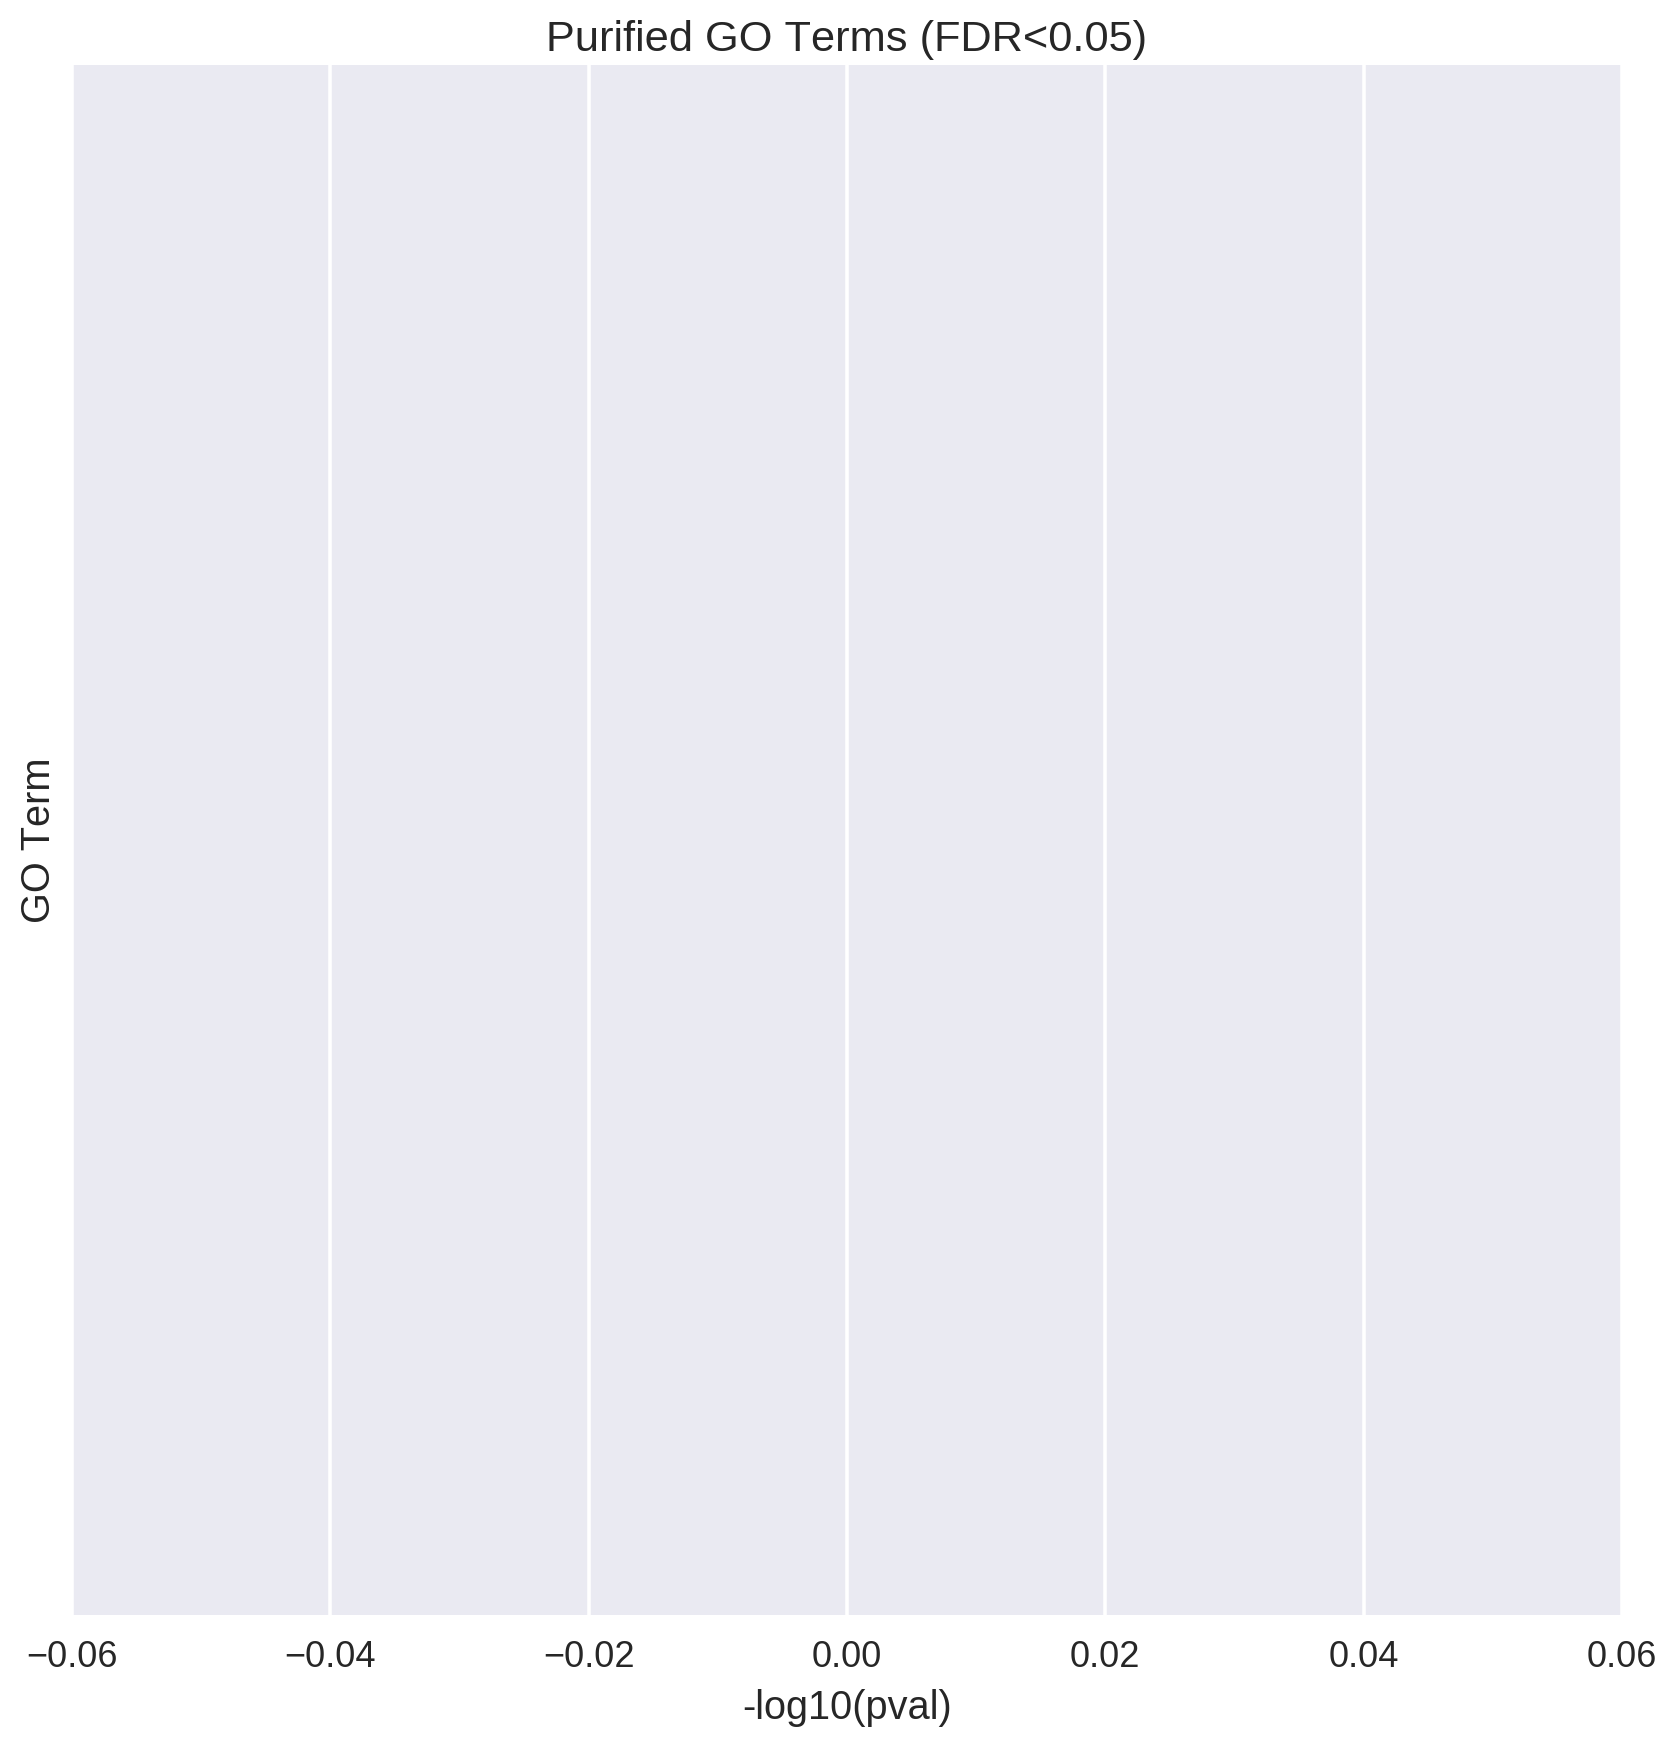

In [140]:
results = pd.read_csv('notx_results.tsv',sep='\t', skiprows=2)

maxTerms = 20
fdr_threshold = 0.05
significant_results = results[results['p_fdr'] < fdr_threshold]

# seperate enriched and purified results
enriched_results = significant_results[significant_results['enrichment']=='e']
purified_results= significant_results[significant_results['enrichment']=='p']

# plot enriched results
numTerms = np.min([maxTerms, enriched_results.shape[0]])
plt.figure(figsize = (10,10))
plt.barh(range(numTerms), 
         -1*np.log10(enriched_results.head(numTerms)['p_uncorrected']), 
         height=0.5,
       )
plt.yticks(np.arange(numTerms)+0.25, 
           enriched_results.head(numTerms)['description'], 
           fontsize=10)
plt.ylim([0, numTerms])
plt.ylabel('GO Term')
plt.xlabel('-log10(pval)')
plt.title('Enriched GO Terms (FDR<' + str(fdr_threshold) + ')')
plt.show()

# plot purified results
numTerms = np.min([maxTerms, purified_results.shape[0]])

plt.figure(figsize = (10,10))
plt.barh(range(numTerms), 
         -1*np.log10(purified_results.head(numTerms)['p_uncorrected']), 
         height=0.5,
       )
plt.yticks(np.arange(numTerms)+0.25, 
           purified_results.head(numTerms)['description'], 
           fontsize=10)
plt.ylim([0, numTerms])
plt.ylabel('GO Term')
plt.xlabel('-log10(pval)')
plt.title('Purified GO Terms (FDR<' + str(fdr_threshold) + ')')
plt.show()